In [16]:
#importing dependencies
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

# this class define the storage buffer of the environment  

class StorageBuffer:
    def __init__(self):
        self.reset()
        self.episode_rewards = []  # Store rewards for each episode
        self.episode_lengths = []  # Store lengths for each episode
        
    def reset(self):
        # Current episode storage
        self.states = []
        self.actions = []
        self.rewards = []
        self.log_probs = []
        self.dones = []
        self.next_state = None
        self.current_reward = 0
        
    def add_step(self, state, action, reward, log_prob, done, next_state=None):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.log_probs.append(log_prob)
        self.dones.append(done)
        self.current_reward += reward
        
        if done:
            self.next_state = next_state
            self.episode_rewards.append(self.current_reward)
            self.episode_lengths.append(len(self.rewards))
            
    def get_episode_data(self):
        return {
            'states': torch.FloatTensor(np.array(self.states)),
            'actions': torch.tensor(self.actions),
            'rewards': torch.tensor(self.rewards),
            'log_probs': torch.tensor(self.log_probs),
            'dones': torch.tensor(self.dones),
            'next_state': torch.FloatTensor(self.next_state).unsqueeze(0) if self.next_state is not None else None
        }
    
    def get_statistics(self):
        if not self.episode_rewards:
            return {"mean_reward": 0, "max_reward": 0, "min_reward": 0, "mean_length": 0}
        
        return {
            "mean_reward": np.mean(self.episode_rewards),
            "max_reward": np.max(self.episode_rewards),
            "min_reward": np.min(self.episode_rewards),
            "mean_length": np.mean(self.episode_lengths),
            "current_reward": self.current_reward,
            "current_length": len(self.rewards)
        }

#the policy and value networks
# i used small model since it simple game but you can make it bigger if you want

class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, action_dim),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, x):
        return self.fc(x)

class ValueNetwork(nn.Module):
    def __init__(self, state_dim):
        super(ValueNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.fc(x)

In [17]:
# this is our environment that will train our ppo agent on 
import gymnasium as gym

env = gym.make("FrozenLake-v1", render_mode="human")
observation, info = env.reset()

episode_over = False
while not episode_over:
    action = env.action_space.sample()  
    observation, reward, terminated, truncated, info = env.step(action)

    episode_over = terminated or truncated

env.close()
print('observation space observation_space',env.observation_space.n)
print('action space',env.action_space.n)

observation space observation_space 16
action space 4


In [18]:
# the ppo agent class uses the value and policy network and adamW optimizer and MSELoss
from torch.utils.data import TensorDataset, DataLoader

# we use one hot encoding to encode the states giving one to the index of the state and 0 otherwise
def one_hot_state(state, state_dim):
    one_hot = np.zeros(state_dim, dtype=np.float32)
    one_hot[state] = 1.0
    return one_hot


class PPOAgent():
    def __init__(self,state_dim,action_dim,lr=3e-4,gamma = 0.99,eps_clip =  0.2 , k_epochs=10):
        self.policy  = PolicyNetwork(state_dim,action_dim)
        self.old_policy  = PolicyNetwork(state_dim,action_dim)
        self.old_policy.load_state_dict(self.policy.state_dict())
        self.value_function = ValueNetwork(state_dim)
        self.policy_optimizer =  optim.AdamW(self.policy.parameters(),lr=lr)
        self.value_optimizer =  optim.AdamW(self.value_function.parameters(),lr)
        self.gamma = gamma
        self.k_epochs = k_epochs 
        self.eps_clip  = eps_clip
        self.mse_loss = nn.MSELoss()
    def select_action(self,state):
        # this function used to select action by our old policy and returning the log_prob of it 
        state = torch.tensor(state,dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            action_prob  =  self.old_policy(state)
        disc =  Categorical(action_prob)
        action  = disc.sample()
        return action.item(),disc.log_prob(action)
    def compute_advantages(self, rewards, values, next_value, dones):
        # this function calculate the advantage  function
        advantages = []
        gae = 0
        for t in reversed(range(len(rewards))):
            delta = rewards[t] + self.gamma * (1 - float(dones[t])) * next_value - values[t]
            gae = delta + self.gamma * (1 - float(dones[t])) * gae
            advantages.insert(0, gae)
            next_value = values[t]
        advantages  =  torch.tensor(advantages, dtype=torch.float32)
            
        return (advantages - advantages.mean()) / (advantages.std() + 1e-8)
    
    def save_model(self, path):

        torch.save({
            'policy_state_dict': self.policy.state_dict(),
            'value_state_dict': self.value_function.state_dict(),
        }, path)

    def load_model(self, path):

        checkpoint = torch.load(path)
        self.policy.load_state_dict(checkpoint['policy_state_dict'])
        self.old_policy.load_state_dict(checkpoint['policy_state_dict'])
        self.value_function.load_state_dict(checkpoint['value_state_dict'])
    
    def update(self,buffer):
        # update is the main function to train the model using ppo algorithm
        data = buffer.get_episode_data()
        states = data['states']
        actions = data['actions']
        rewards = data['rewards']
        dones = data['dones']
        log_probs_old = data['log_probs']

        values = self.value_function(states).squeeze().detach()

        if data['next_state'] is not None:
            next_value = self.value_function(data['next_state']).item()
        else:
            next_value = 0.0
        
        advantages = self.compute_advantages(rewards, values, next_value, dones)
        targets = advantages + values

        dataset = TensorDataset(states, actions, log_probs_old, advantages, targets)
        dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

        policy_losses = []
        value_losses = []

        for _ in range(self.k_epochs):
            for batch in dataloader:
                batch_states, batch_actions, batch_old_log_probs, batch_advantages, batch_targets = batch

                action_probs = self.policy(batch_states)
                dist = Categorical(action_probs)
                log_probs = dist.log_prob(batch_actions)

                ratios = torch.exp(log_probs - batch_old_log_probs)
                surr1 = ratios * batch_advantages
                surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * batch_advantages

                loss_actor = -torch.min(surr1, surr2).mean()
                values_pred = self.value_function(batch_states).squeeze()
                loss_critic = self.mse_loss(values_pred, batch_targets)

                self.policy_optimizer.zero_grad()
                loss_actor.backward()
                self.policy_optimizer.step()

                self.value_optimizer.zero_grad()
                loss_critic.backward()
                self.value_optimizer.step()

                policy_losses.append(loss_actor.item())
                value_losses.append(loss_critic.item())

        self.old_policy.load_state_dict(self.policy.state_dict())

        return {
            'policy_loss': np.mean(policy_losses),
            'value_loss': np.mean(value_losses),
            'average_value': values.mean().item()
        }


def train_ppo(num_episodes=2000,max_time_steps=200):
        
        # this function uses the interact with the environment and passes data to the update function to apply ppo on the model

        env = gym.make("FrozenLake-v1", is_slippery=False)
        state_dim  =  env.observation_space.n
        action_dim =   env.action_space.n
        best_reward = 0
        reward_progress = []
        agent  =  PPOAgent(state_dim,action_dim)
        storage = StorageBuffer()
        for episode in range(num_episodes):
            state, _ = env.reset()
            state = np.array(state)
            storage.reset()  
            for t in range(max_time_steps):
                action ,old_log_prob  = agent.select_action(one_hot_state(state, state_dim))
                next_state, reward, terminated, truncated, _ = env.step(action)
                reward_progress.append(reward)
                done = terminated or truncated
                storage.add_step(one_hot_state(state, state_dim), action, reward, old_log_prob, done, one_hot_state(next_state, state_dim) if done else None)
                state = next_state
                if done:
                    break
            agent.update(storage)
            stats = storage.get_statistics()
            if stats['current_reward'] >= best_reward:
                best_reward = stats['current_reward']
                agent.save_model('frozen_lake_ppo.pth')

            print(f"Episode {episode + 1}, Total Reward: {stats['current_reward']}, Best Reward: {best_reward}")


        env.close()
        return agent, storage,reward_progress
    
def test_model(model_path, num_episodes = 10):
    # this function allow us to view the model performance on the environment
    env = gym.make("FrozenLake-v1",render_mode="human", is_slippery=False)
    state_dim  =  env.observation_space.n
    action_dim =   env.action_space.n
    best_reward = 0
    agent  =  PPOAgent(state_dim,action_dim)
    agent.load_model(model_path)

    storage = StorageBuffer()
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        state = np.array(state)
        storage.reset()  # Reset storage for new episode
        done = False
        
        while not done:
            action, log_prob = agent.select_action(one_hot_state(state, state_dim))
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = np.array(next_state)
            
            storage.add_step(one_hot_state(state, state_dim), action, reward, log_prob, done, one_hot_state(next_state, state_dim) if done else None)
            state = next_state
        
        stats = storage.get_statistics()
        print(f"Test Episode {episode + 1}, Total Reward: {stats['current_reward']}")
    
    env.close()
    return storage
            

Starting training for 2000 episodes...
Episode 1, Total Reward: 0.0, Best Reward: 0.0
Episode 2, Total Reward: 0.0, Best Reward: 0.0
Episode 3, Total Reward: 0.0, Best Reward: 0.0
Episode 4, Total Reward: 0.0, Best Reward: 0.0
Episode 5, Total Reward: 0.0, Best Reward: 0.0
Episode 6, Total Reward: 0.0, Best Reward: 0.0
Episode 7, Total Reward: 0.0, Best Reward: 0.0
Episode 8, Total Reward: 0.0, Best Reward: 0.0
Episode 9, Total Reward: 0.0, Best Reward: 0.0
Episode 10, Total Reward: 0.0, Best Reward: 0.0
Episode 11, Total Reward: 0.0, Best Reward: 0.0
Episode 12, Total Reward: 0.0, Best Reward: 0.0
Episode 13, Total Reward: 0.0, Best Reward: 0.0
Episode 14, Total Reward: 0.0, Best Reward: 0.0
Episode 15, Total Reward: 1.0, Best Reward: 1.0
Episode 16, Total Reward: 0.0, Best Reward: 1.0
Episode 17, Total Reward: 0.0, Best Reward: 1.0
Episode 18, Total Reward: 0.0, Best Reward: 1.0
Episode 19, Total Reward: 0.0, Best Reward: 1.0
Episode 20, Total Reward: 0.0, Best Reward: 1.0
Episode 21

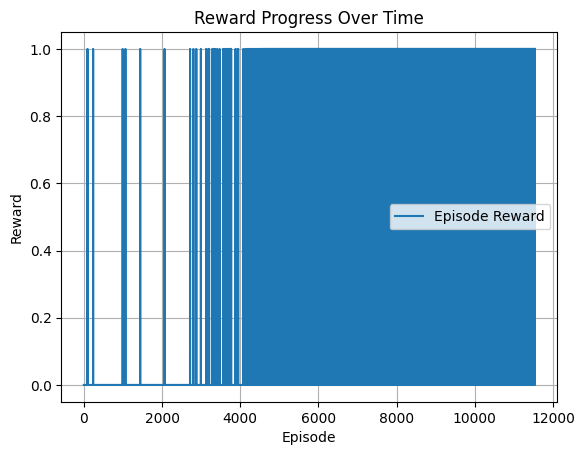


Starting model testing...
Test Episode 1, Total Reward: 1.0
Test Episode 2, Total Reward: 1.0
Test Episode 3, Total Reward: 1.0
Test Episode 4, Total Reward: 1.0
Test Episode 5, Total Reward: 1.0

Testing completed! Test statistics:
Mean test reward: 1.00
Max test reward: 1.00
Min test reward: 1.00


In [19]:
import matplotlib.pyplot as plt
if __name__ == "__main__":
    # this is for training and testing the model
    # since this environment only gives reward at the end of the episode we need to give it more training
    num_episodes = 2000  # You can change this number
    print(f"Starting training for {num_episodes} episodes...")
    agent, train_storage,reward_progress = train_ppo(num_episodes=num_episodes)
    
    print("\nTraining completed! Training statistics:")
    train_stats = train_storage.get_statistics()
    print(f"Mean reward: {train_stats['mean_reward']:.2f}")
    print(f"Max reward: {train_stats['max_reward']:.2f}")
    print(f"Mean episode length: {train_stats['mean_length']:.2f}")
    model_path = "frozen_lake_ppo.pth"
    
    plt.plot(reward_progress, label='Episode Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Reward Progress Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print("\nStarting model testing...")
    test_storage = test_model(model_path, num_episodes=5)
    
    print("\nTesting completed! Test statistics:")
    test_stats = test_storage.get_statistics()
    print(f"Mean test reward: {test_stats['mean_reward']:.2f}")
    print(f"Max test reward: {test_stats['max_reward']:.2f}")
    print(f"Min test reward: {test_stats['min_reward']:.2f}")



In [4]:
# testing the model with the saved params

model_path = "frozen_lake_ppo.pth"
    
print("\nStarting model testing...")
test_storage = test_model(model_path, num_episodes=5)

print("\nTesting completed! Test statistics:")
test_stats = test_storage.get_statistics()
print(f"Mean test reward: {test_stats['mean_reward']:.2f}")
print(f"Max test reward: {test_stats['max_reward']:.2f}")
print(f"Min test reward: {test_stats['min_reward']:.2f}")


Starting model testing...
Test Episode 1, Total Reward: 1.0
Test Episode 2, Total Reward: 1.0
Test Episode 3, Total Reward: 1.0
Test Episode 4, Total Reward: 1.0
Test Episode 5, Total Reward: 1.0

Testing completed! Test statistics:
Mean test reward: 1.00
Max test reward: 1.00
Min test reward: 1.00
